In [411]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

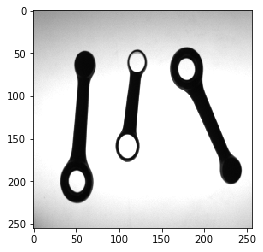

In [412]:
img = cv2.imread('images/TESI00.BMP')
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray');

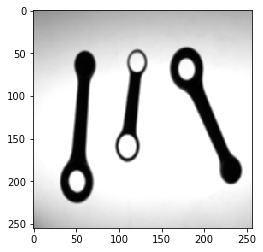

In [413]:
# Blur the image to threshold the image more easily

smoothedImg = cv2.blur(imgGray, (3, 3))
# smoothedImg = cv2.medianBlur(img, 5)
# smoothedImg = cv2.GaussianBlur(img, (7, 7), 0)
plt.imshow(smoothedImg, cmap='gray');

Smoothing is done to prevent error in binarization (i.e.: TESI47.BMP)

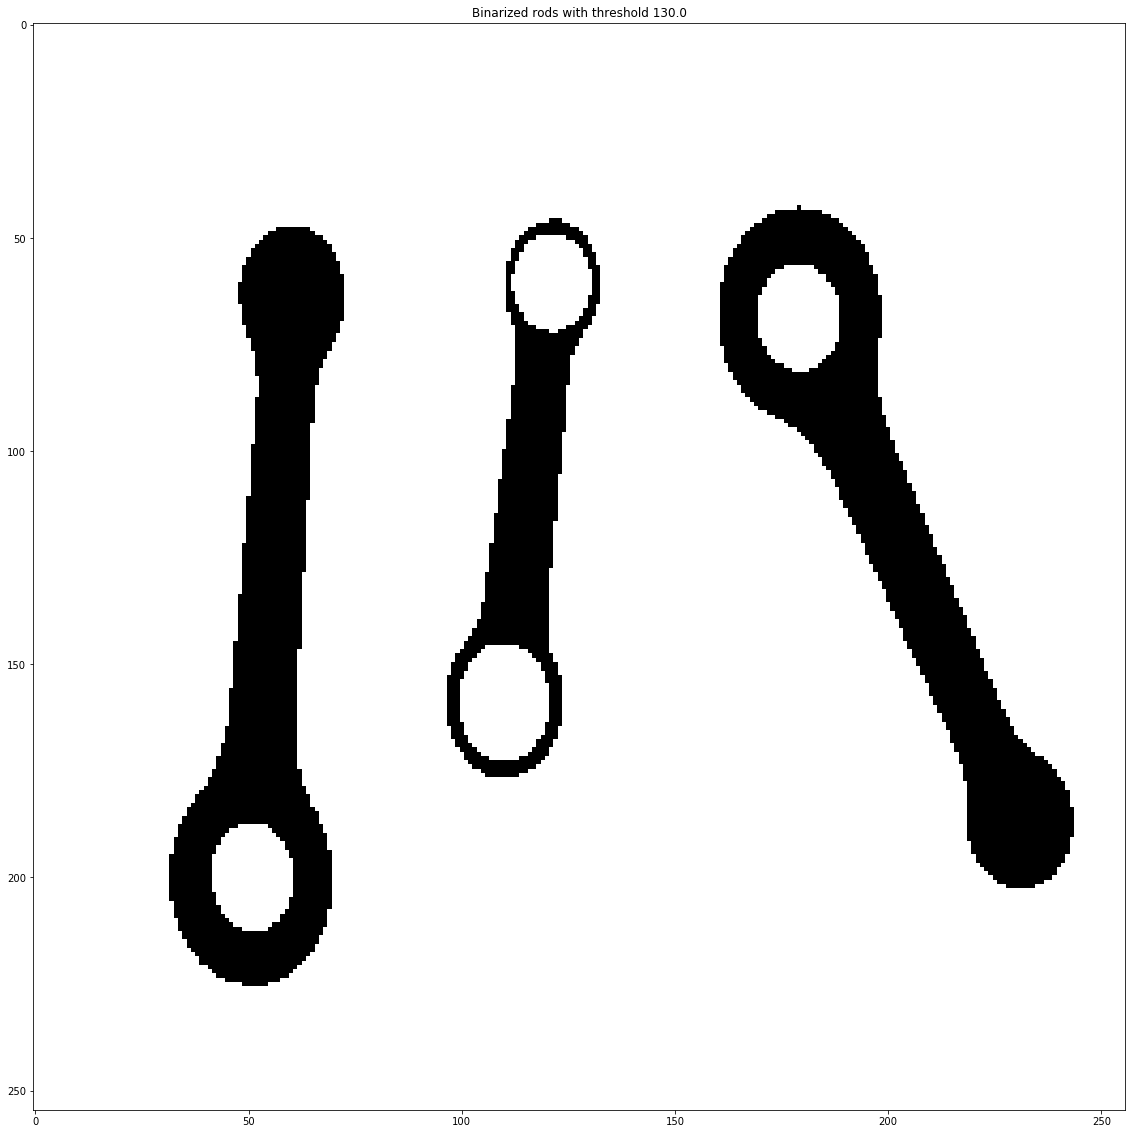

In [414]:
# Smooth the image with Otsu's algorithm
threshold, threshImg = cv2.threshold(smoothedImg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize=(20, 20))
plt.title('Binarized rods with threshold ' + str(threshold))
plt.imshow(threshImg, cmap='gray');

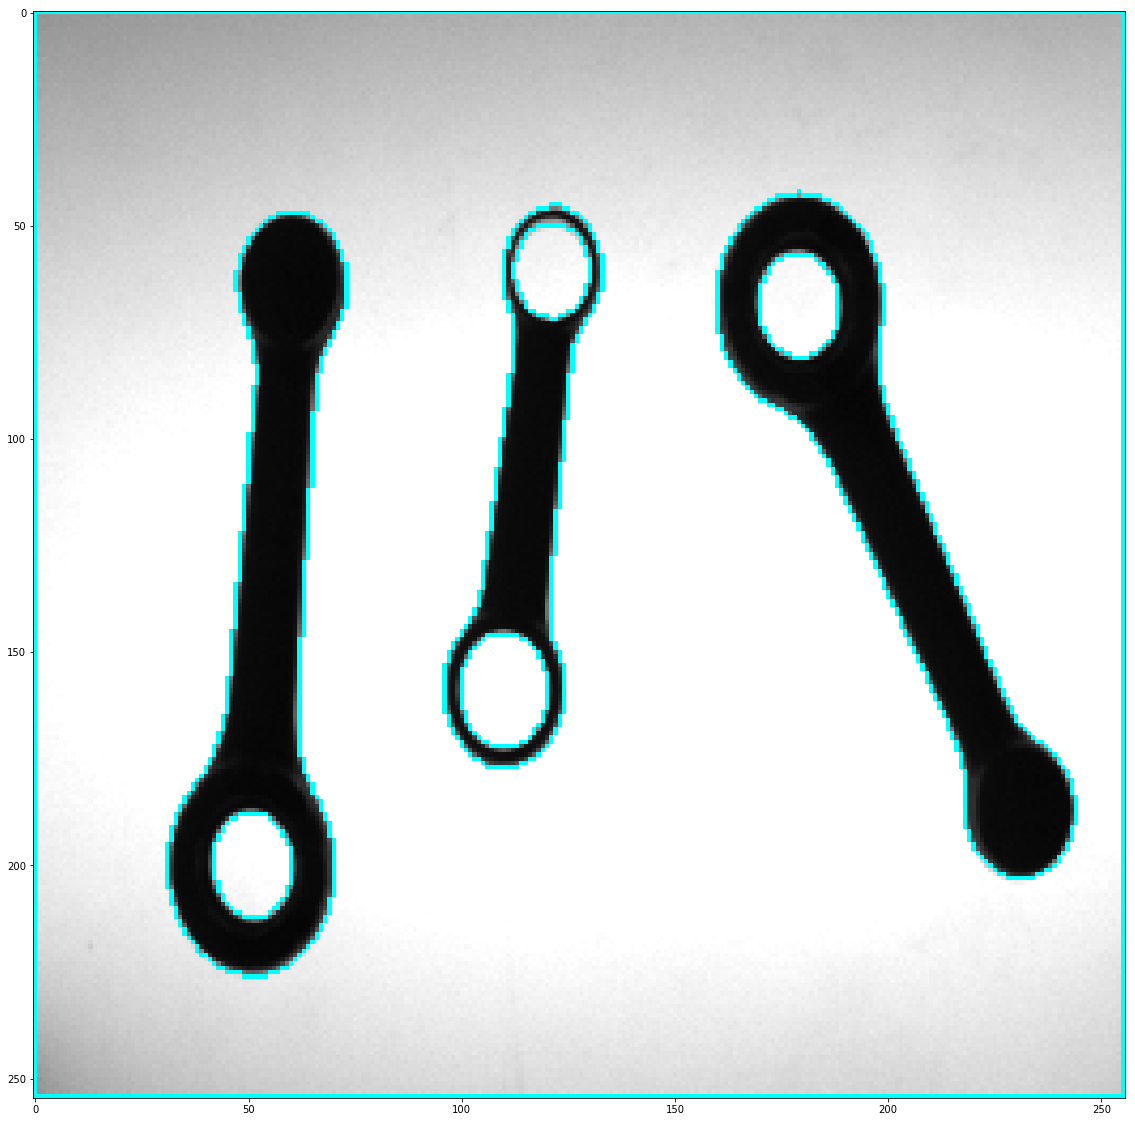

In [415]:
_, contours, hierarchy = cv2.findContours(threshImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contoursImg = img.copy()

cv2.drawContours(contoursImg, contours, -1, (0, 255, 255), 1)
plt.figure(figsize=(20, 20))
plt.imshow(contoursImg);

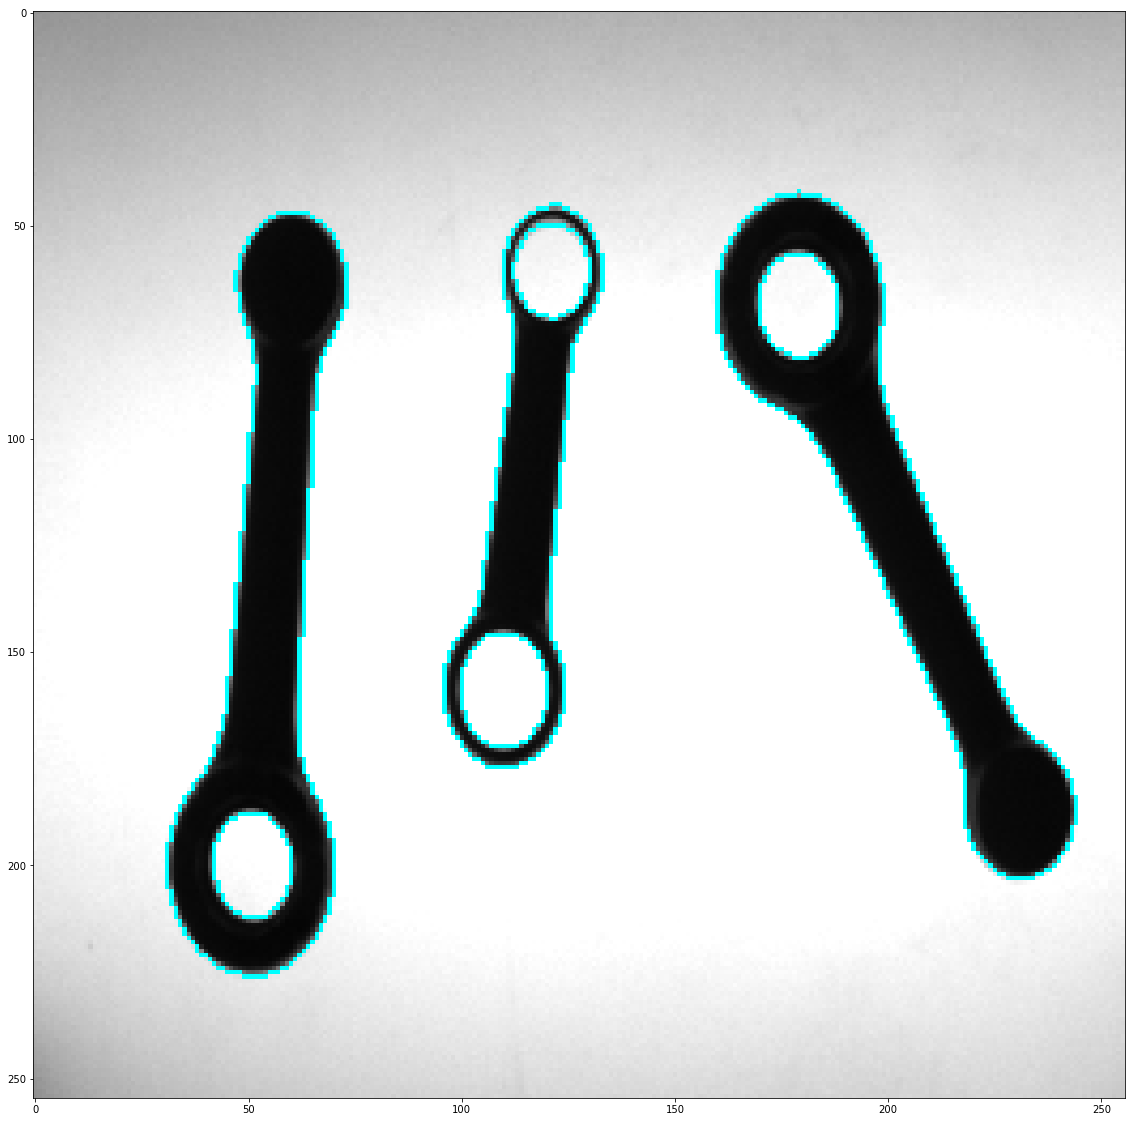

In [416]:
imgBorderIndex = np.argmax([cv2.contourArea(cnt) for cnt in contours])
allContours = np.delete(contours, imgBorderIndex)
allHierarchy = np.delete(hierarchy.reshape((-1, 4)), imgBorderIndex, axis=0)

contoursImg = img.copy()

cv2.drawContours(contoursImg, allContours, -1, (0, 255, 255), 1)
plt.figure(figsize=(20, 20))
plt.imshow(contoursImg);

In [417]:
n_rods = np.sum(allHierarchy[:,3] == 0)
n_rods

3

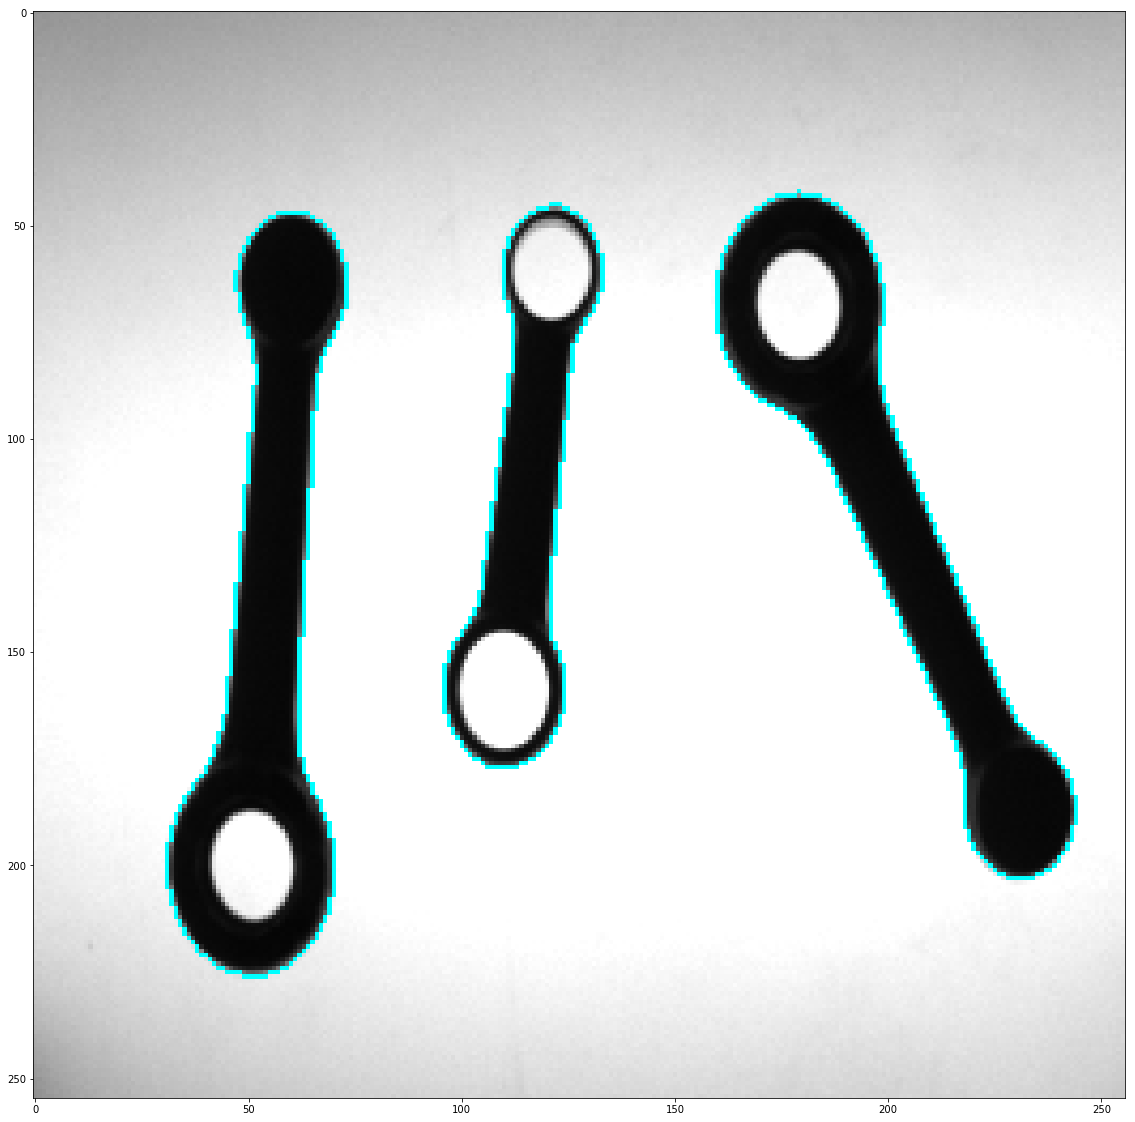

In [418]:
# Filter the outer contours
rodsContours = allContours[allHierarchy[:, 3] == 0]

rodsContoursImg = img.copy()

cv2.drawContours(rodsContoursImg, rodsContours, -1, (0, 255, 255), 1)
plt.figure(figsize=(20, 20))
plt.imshow(rodsContoursImg);

In [419]:
print(allHierarchy[:, 3] == 0)
print(allHierarchy)

[ True False  True False False  True False]
[[ 3 -1  2  0]
 [-1 -1 -1  1]
 [ 6  1  4  0]
 [ 5 -1 -1  3]
 [-1  4 -1  3]
 [-1  3  7  0]
 [-1 -1 -1  6]]


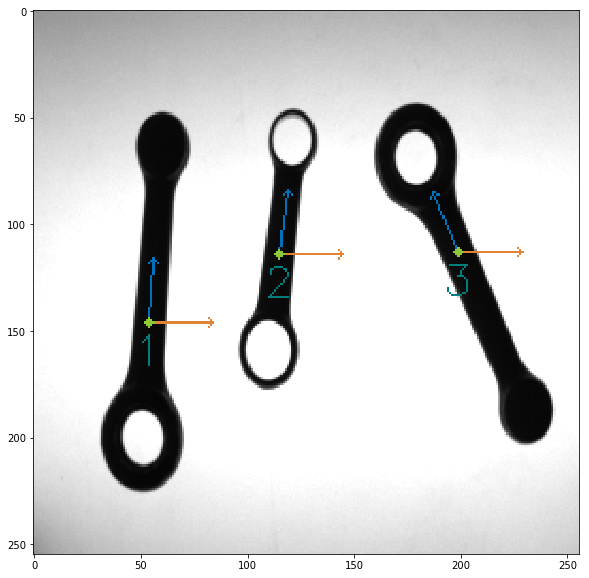

In [420]:
posImg = img.copy()
i = 1

for cnt in rodsContours:
    # Compute center of mass
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    # Compute angle
    (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
    angle = int(180 + ((angle % 180) - 90) * (-1)) % 180
    arrowLength = 30
    radians = - angle * np.pi / 180
    #cv2.circle(posImg, (cx, cy), angle_radius, (228, 204, 55))
    
    x2 = int(round(np.cos(radians) * arrowLength + cx))
    y2 = int(round(np.sin(radians) * arrowLength + cy))
    
    cv2.arrowedLine(posImg, (cx, cy), (cx + arrowLength, cy), (225, 131, 53))
    cv2.arrowedLine(posImg, (cx, cy), (x2, y2), (0, 114, 187))
    
    cv2.circle(posImg, (cx, cy), 2, (143, 201, 58), -1)
    
    cv2.putText(posImg, str(i), (cx - 7, cy + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.66, (0, 125, 125), 1)
    # cv2.putText(posImg, str(angle), (cx + 5, cy + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.66, (0, 225, 0), 1)
    
    i += 1
    
plt.figure(figsize=(10, 10))
plt.imshow(posImg);